# scEU-seq organoid

This tutorial uses the intestine organoid data from Battich, et al (2020). This tutorial is the second one of the two tutorials for demonstrating how dynamo can use used to analyze the scEU-seq data. Please refer the [cell cycle](https://dynamo-release.readthedocs.io/en/latest/scEU_seq_rpe1_analysis_kinetic.html) tutorial for details on how to analyze the cell cycle dataset.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import dynamo as dyn
import anndata
import pandas as pd
import numpy as np
import scipy.sparse

from anndata import AnnData
from scipy.sparse import csr_matrix

# dyn.get_all_dependencies_version()

## Load data

In [3]:
organoid = dyn.sample_data.scEU_seq_organoid()

|-----> Downloading scEU_seq data
|-----> Downloading data to ./data/organoid.h5ad


In [4]:
organoid

AnnData object with n_obs × n_vars = 3831 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time'
    var: 'ID', 'NAME'
    layers: 'sl', 'su', 'ul', 'uu'

In [5]:
# mapping:
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
 }

organoid.obs['cell_type'] = organoid.obs.som_cluster_id.map(cell_mapper).astype('str')


## typical dynamo analysis workflow


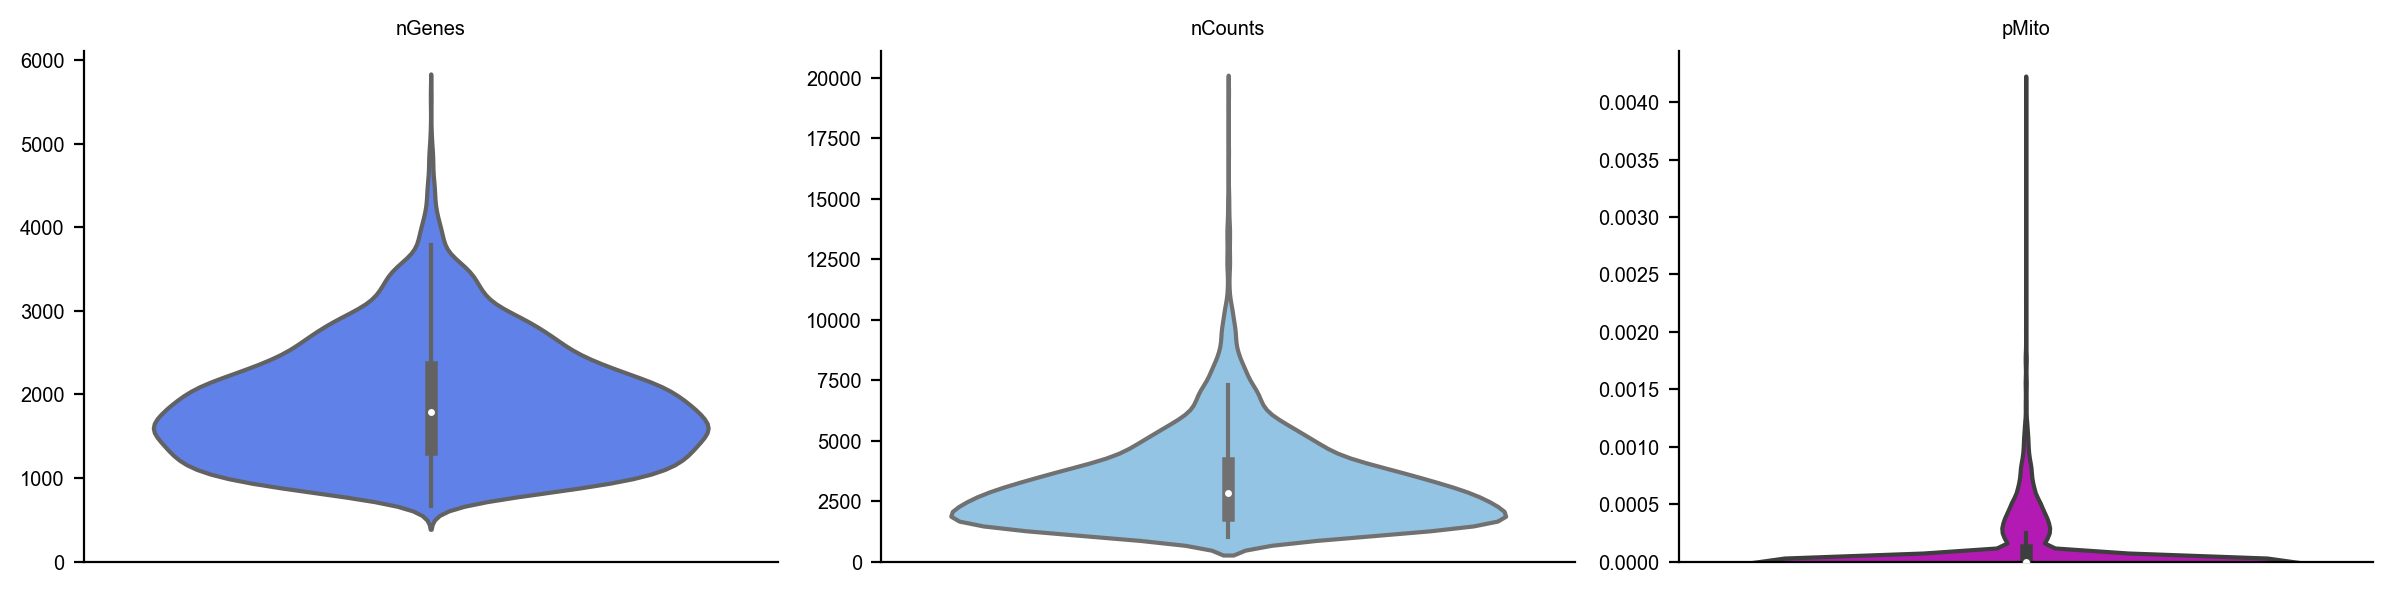

In [6]:
dyn.pl.basic_stats(organoid)

In [7]:
organoid

AnnData object with n_obs × n_vars = 3831 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito'
    var: 'ID', 'NAME', 'nCells', 'nCounts'
    layers: 'sl', 'su', 'ul', 'uu'

In [8]:
organoid.obs

well_id batch_id treatment_id      log10_gfp  rotated_umap1  \
1         14       01    Pulse_120  12.8929281522  23.0662174225   
2         15       01    Pulse_120  5.85486775252   25.710735321   
3         16       01    Pulse_120  7.45690471634  26.7709560394   
4         17       01    Pulse_120  94.2814535609  21.2927913666   
5         21       01    Pulse_120  47.1412266395  19.9096126556   
...      ...      ...          ...            ...            ...   
3827     378       12    Pulse_120   32.496816667  20.7663478851   
3828     379       12    Pulse_120  78.1198193763  20.1073760986   
3829     380       12    Pulse_120   53.249846399  20.1618804932   
3830     381       12   Pulse_dmso  16.7070737849  15.4272613525   
3831     383       12   Pulse_dmso  93.3716092195  21.5953540802   

        rotated_umap2 som_cluster_id monocle_branch_id monocle_pseudotime  \
1      -3.47039175034              6                 2      6.08688834859   
2      -1.31835341454              2                 2      9.14740876358   
3      -1.06682777405              2                 2      9.69134627386   
4     0.0159659013152             11                 2       4.2635104705   
5      0.884054124355             11                 1      2.62248093423   
...               ...            ...               ...                ...   
3827   -3.72811675072              8                 3      7.32939908351   
3828   -2.65023303032              8                 3      5.10436147713   
3829   -3.83158016205              8                 3      6.43742448317   
3830   -2.15779066086             10                 1     0.657880511889   
3831   -3.90664196014              6                 2      4.81727202212   

     exp_type  time     cell_type  nGenes  nCounts  pMito  
1       Pulse   120      TA cells    1054   1426.0    0.0  
2       Pulse   120   Enterocytes    1900   3712.0    0.0  
3       Pulse   120   Enterocytes    2547   6969.0    0.0  
4       Pulse   120    Stem cells    1004   1263.0    0.0  
5       Pulse   120    Stem cells     927   1144.0    0.0  
...       ...   ...           ...     ...      ...    ...  
3827    Pulse   120    Stem cells    2268   3918.0    0.0  
3828    Pulse   120    Stem cells    2131   3619.0    0.0  
3829    Pulse   120    Stem cells    2141   3603.0    0.0  
3830    Pulse  dmso  Goblet cells    1158   1683.0    0.0  
3831    Pulse  dmso      TA cells    1374   1838.0    0.0  

[3831 rows x 15 columns]

In [9]:
organoid.obs.groupby(['exp_type', 'time']).agg('count')

well_id  batch_id  treatment_id  log10_gfp  rotated_umap1  \
exp_type time                                                              
Chase    0         660       660           660        660            660   
         45        821       821           821        821            821   
         120         0         0             0          0              0   
         360       646       646           646        646            646   
         dmso        0         0             0          0              0   
Pulse    0           0         0             0          0              0   
         45          0         0             0          0              0   
         120      1373      1373          1373       1373           1373   
         360         0         0             0          0              0   
         dmso      331       331           331        331            331   

               rotated_umap2  som_cluster_id  monocle_branch_id  \
exp_type time                                                     
Chase    0               660             660                660   
         45              821             821                821   
         120               0               0                  0   
         360             646             646                646   
         dmso              0               0                  0   
Pulse    0                 0               0                  0   
         45                0               0                  0   
         120            1373            1373               1373   
         360               0               0                  0   
         dmso            331             331                331   

               monocle_pseudotime  cell_type  nGenes  nCounts  pMito  
exp_type time                                                         
Chase    0                    660        660     660      660    660  
         45                   821        821     821      821    821  
         120                    0          0       0        0      0  
         360                  646        646     646      646    646  
         dmso                   0          0       0        0      0  
Pulse    0                      0          0       0        0      0  
         45                     0          0       0        0      0  
         120                 1373       1373    1373     1373   1373  
         360                    0          0       0        0      0  
         dmso                 331        331     331      331    331

|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----? 
When analyzing labeling based scRNA-seq without providing `tkey`, dynamo will try to use 
 `time` as the key for labeling time. Please correct this via supplying the correct `tkey`
if needed.
|-----> detected experiment type: one-shot
|-----? Looks like you are using minutes as the time unit.

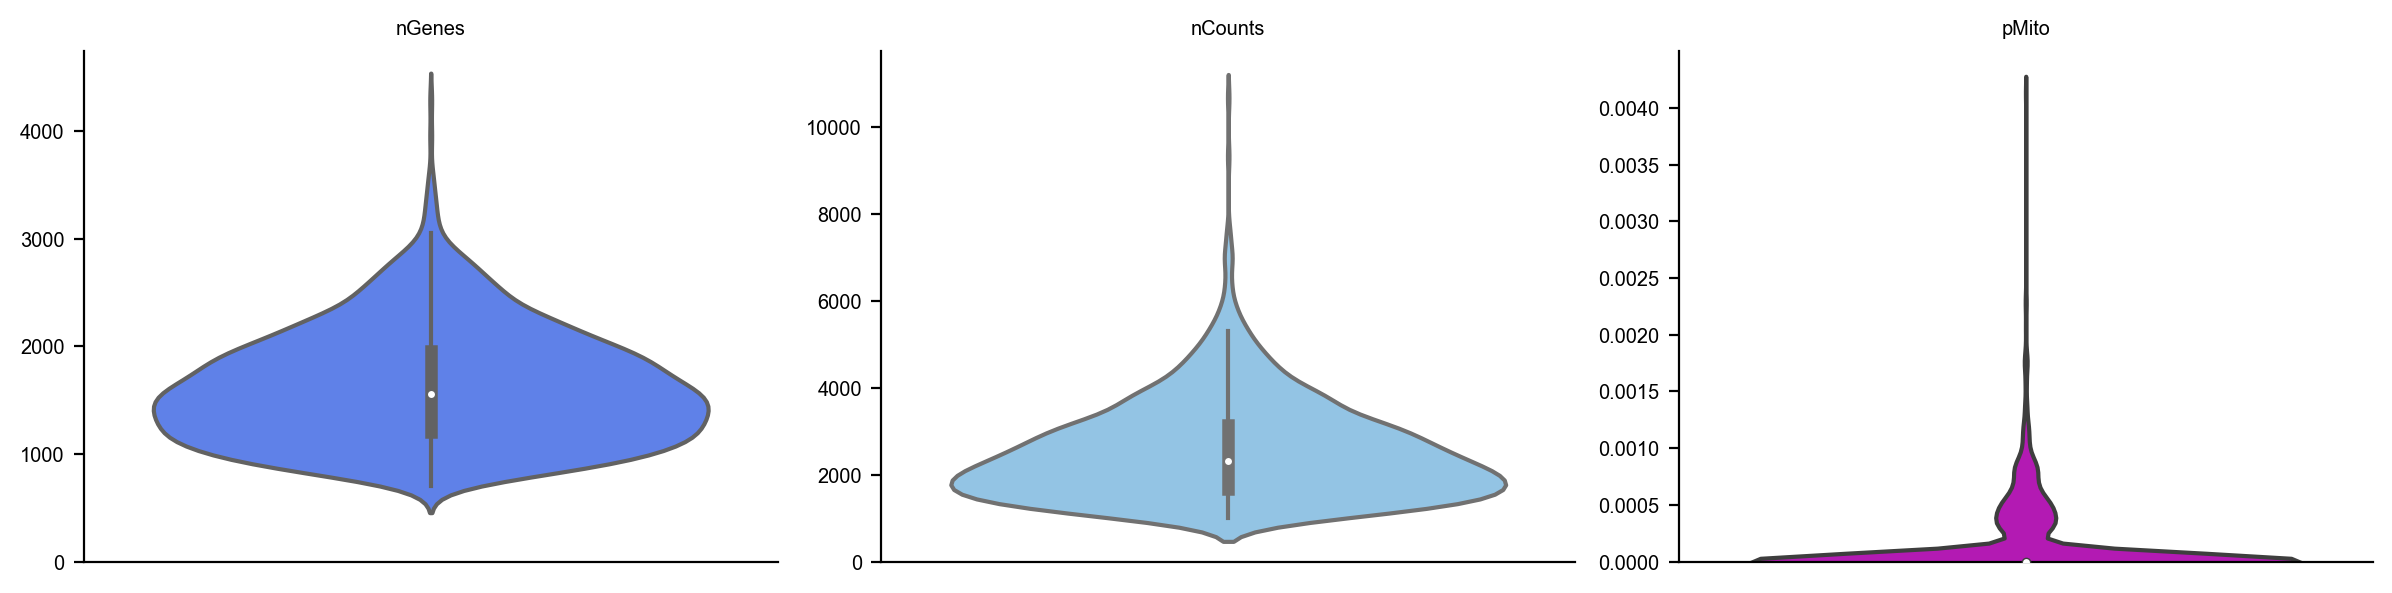

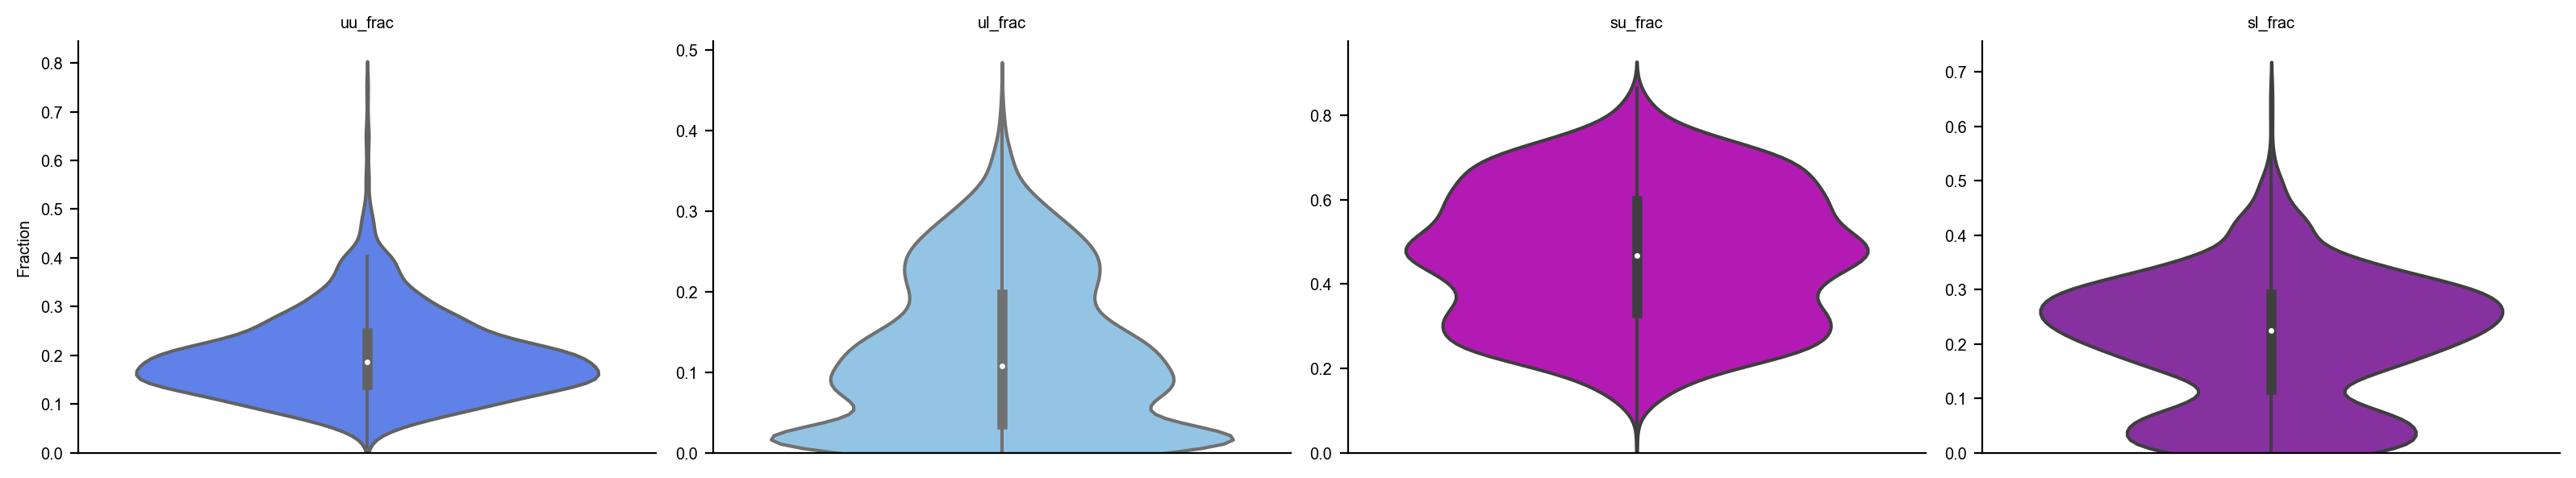

In [10]:
adata = organoid.copy()
adata.obs.time = adata.obs.time.astype('str')
adata.obs.loc[adata.obs['time'] == 'dmso', 'time'] = -1
adata.obs['time'] = adata.obs['time'].astype(float)
adata = adata[adata.obs.time != -1, :]
adata = adata[adata.obs.exp_type == 'Pulse', :]
adata.layers['new'], adata.layers['total'] = adata.layers['ul'] + adata.layers['sl'], adata.layers['su'] + adata.layers['sl'] + adata.layers['uu'] + adata.layers['ul']
del adata.layers['uu'], adata.layers['ul'], adata.layers['su'], adata.layers['sl']
dyn.pp.recipe_monocle(adata, n_top_genes=1000, total_layers=False)
# preprocessor = dyn.pp.Preprocessor(cell_cycle_score_enable=True)
# preprocessor.config_monocle_recipe(adata, n_top_genes=1000)                                  
# preprocessor.preprocess_adata_monocle(adata)
dyn.pl.basic_stats(adata)
dyn.pl.show_fraction(organoid)

In [11]:
adata.obs.time = adata.obs.time/60

In [12]:
adata.obs.time  = adata.obs.time.astype('float')
dyn.tl.dynamics(adata, model='deterministic', tkey='time', assumption_mRNA='ss')

dyn.tl.reduceDimension(adata)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] completed [6.6967s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating gamma: 100%|█████████████████████| 1000/1000 [00:10<00:00, 91.98it/s]


|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [7.4000s]


In [13]:
dyn.tl.cell_velocities(adata, ekey='M_t', vkey='velocity_T', enforce=True)


|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [2.8198s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2473s]


AnnData object with n_obs × n_vars = 1373 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'ID', 'NAME', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'frac', 'use_for_pca', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap

In [14]:
adata.obsm['X_umap_ori'] = adata.obs.loc[:, ['rotated_umap1', 'rotated_umap2']].values.astype(float)

## Visualize time-resolved vector flow learned with dynamo 

|-----> 0 genes are removed because of nan velocity values.
Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2389s]
|-----------> plotting with basis key=X_umap_ori
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


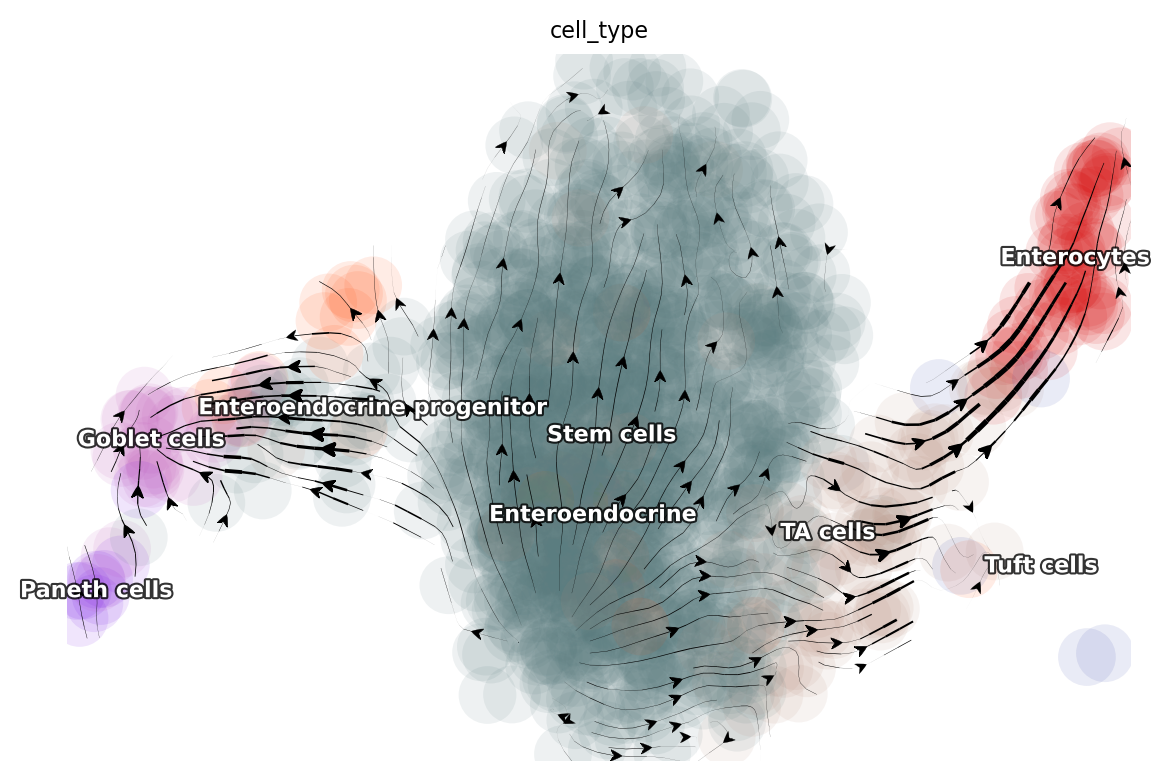

In [ ]:
dyn.tl.cell_velocities(adata, basis='umap_ori')

dyn.pl.streamline_plot(adata, color='cell_type', basis='umap_ori')


|-----------> plotting with basis key=X_umap_ori
|-----------> skip filtering cell_cycle_phase by stack threshold when stacking color because it is not a numeric type


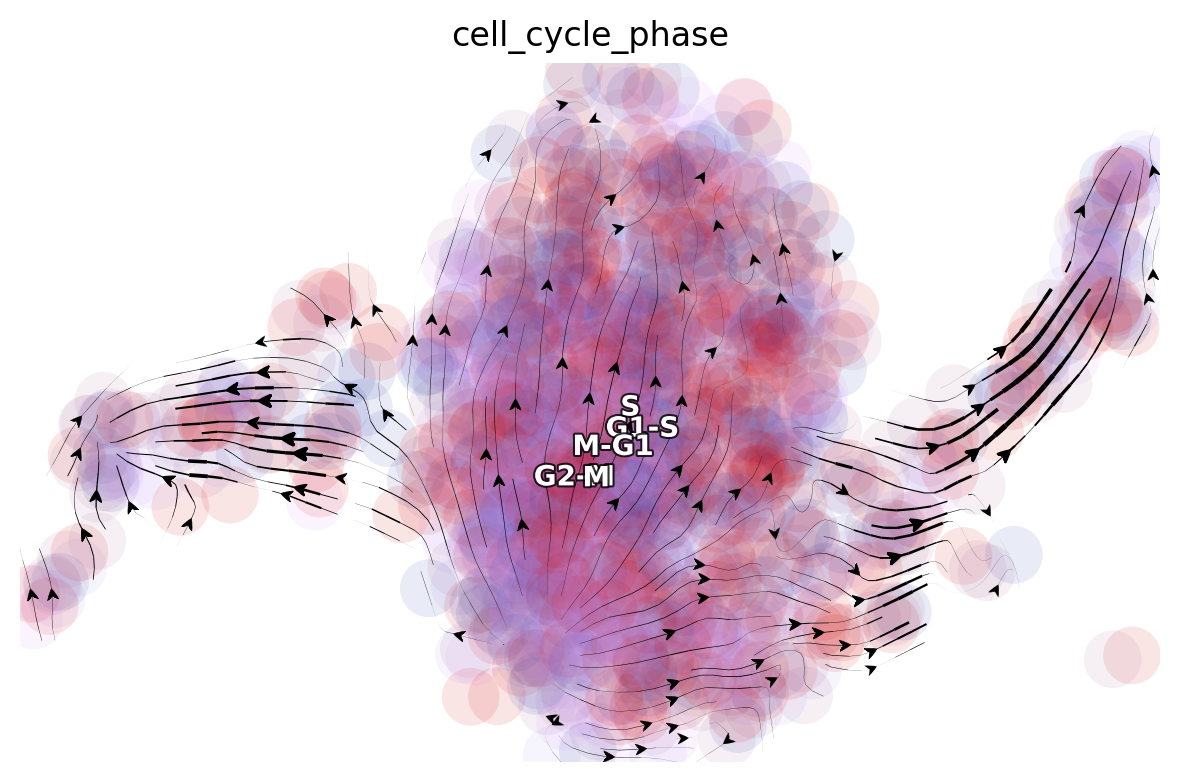

In [ ]:
dyn.pl.streamline_plot(adata, color='cell_cycle_phase', basis='umap_ori')


In [17]:
adata.var_names[adata.var.use_for_transition][:5]

Index(['Cdc45', 'Brat1', 'Ccnd2', 'Ckmt1', 'Pdgfb'], dtype='object')

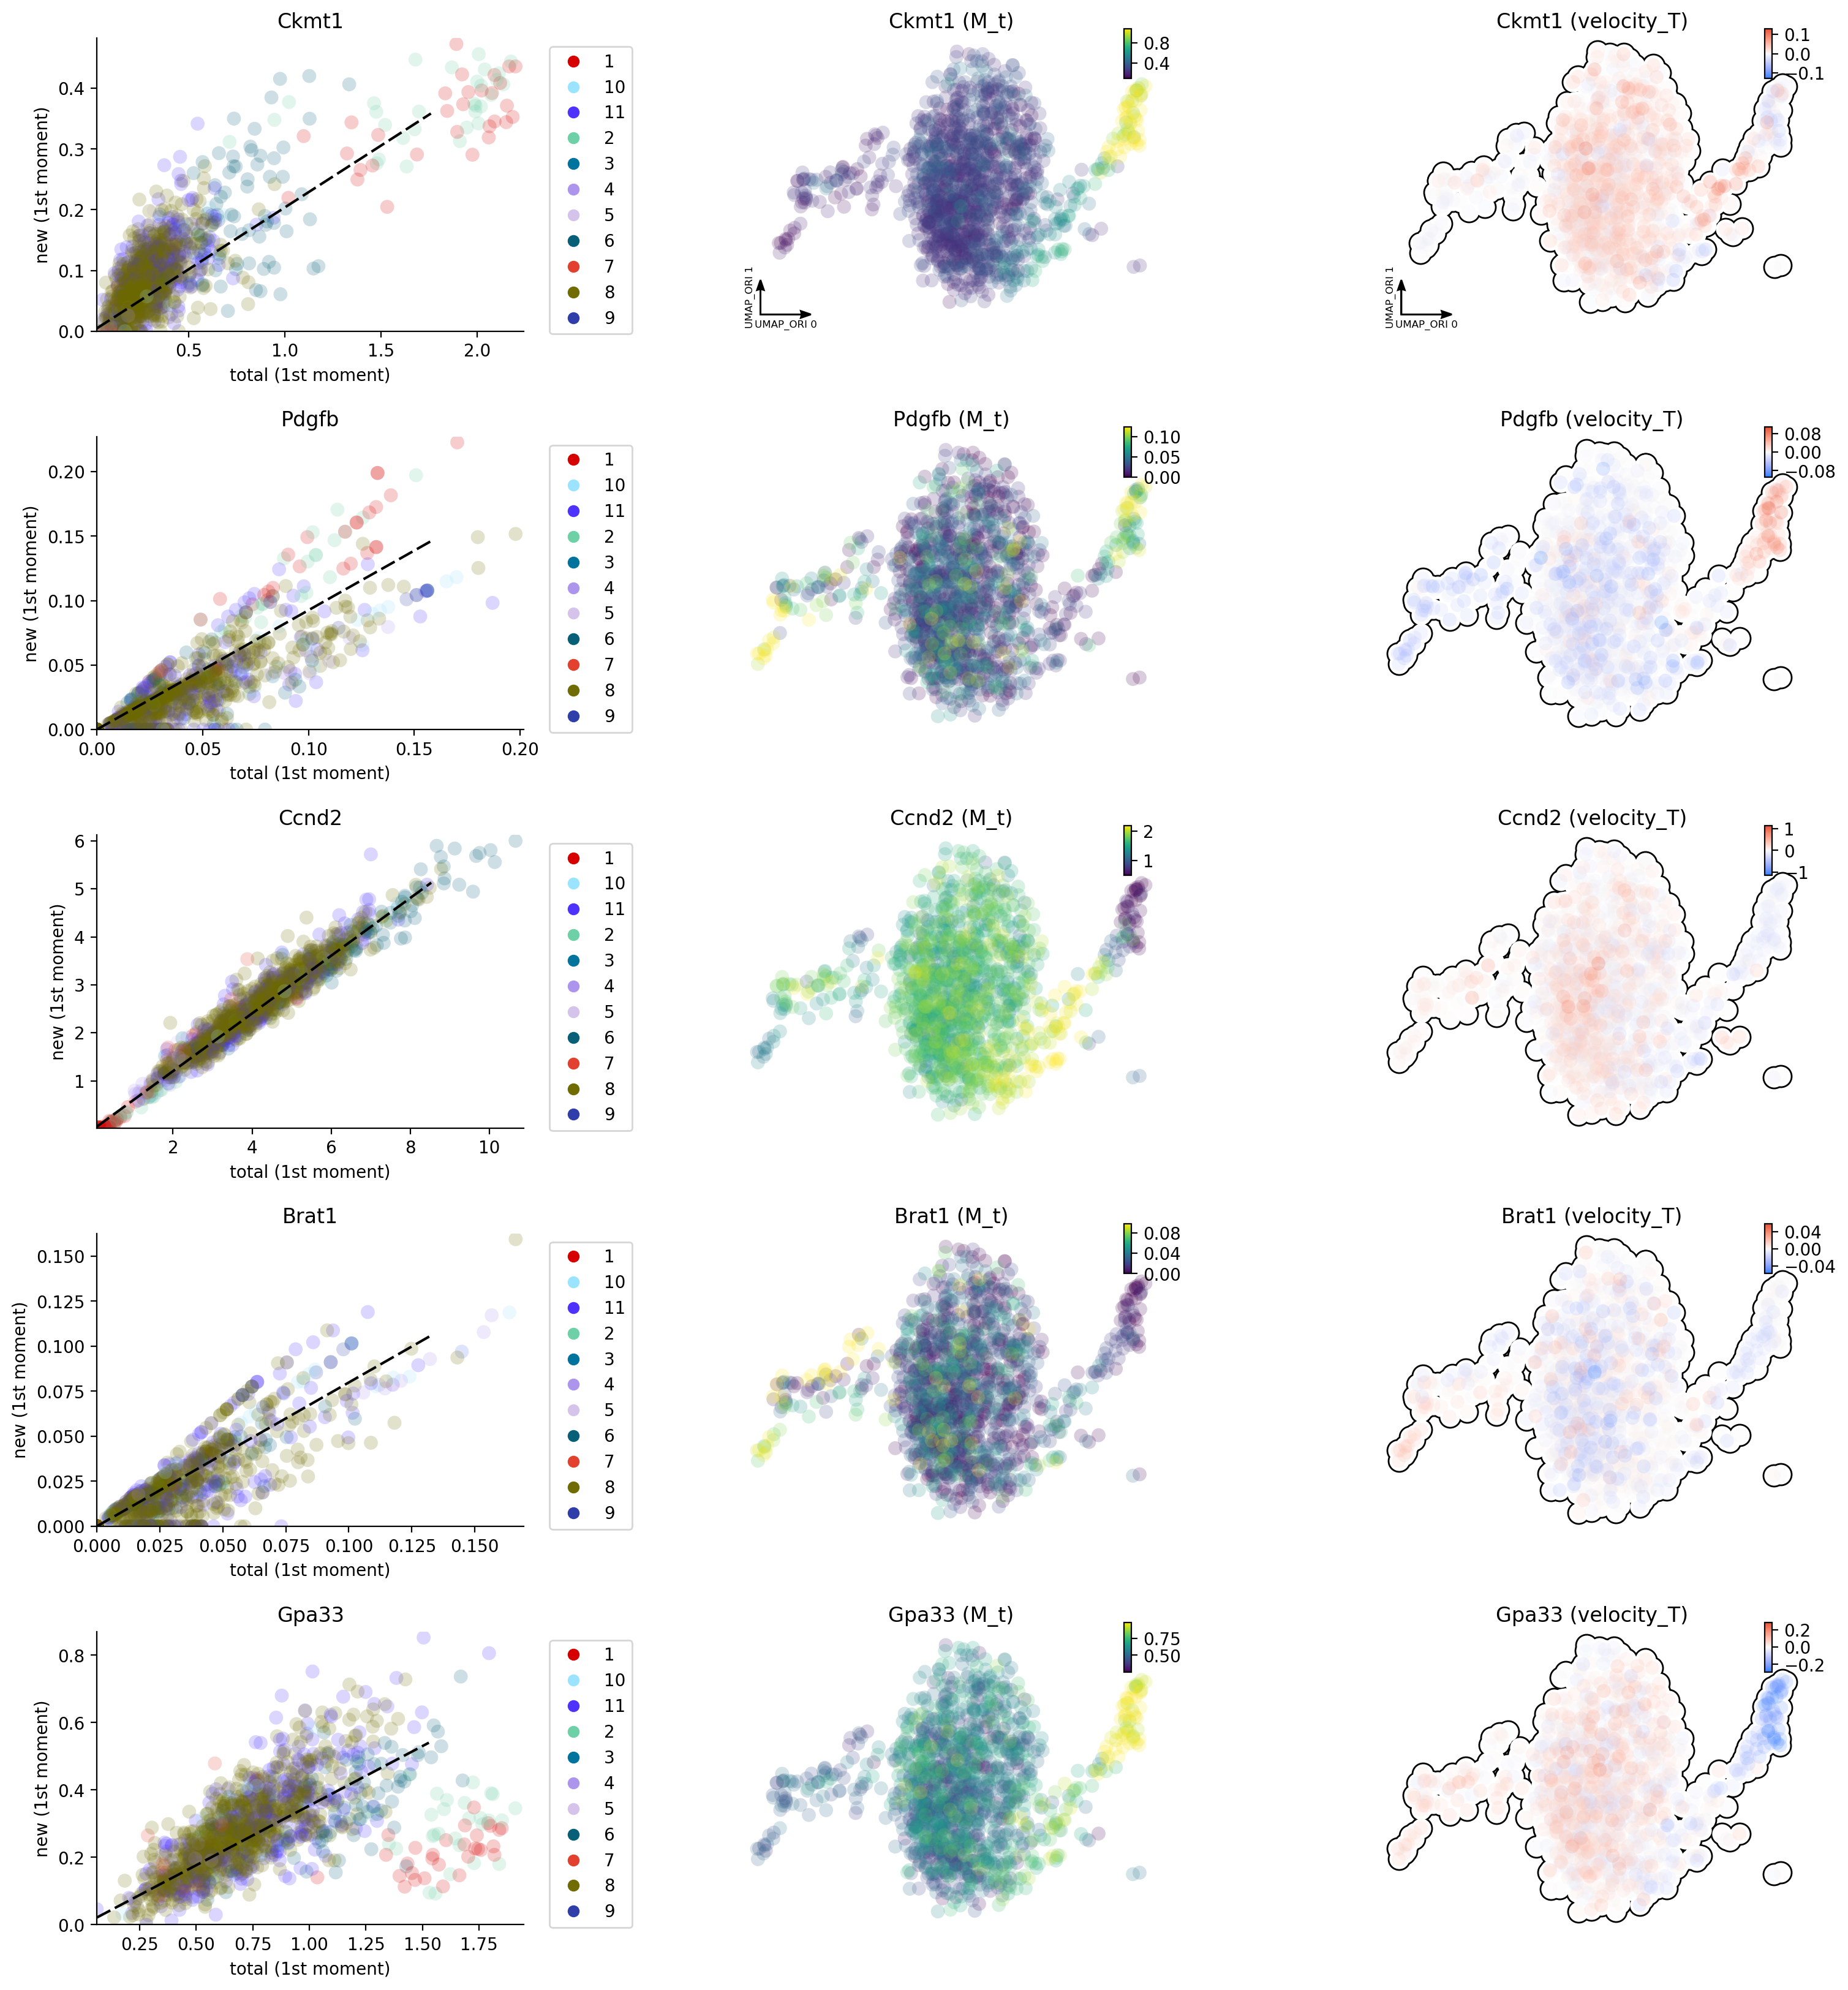

In [ ]:
dyn.pl.phase_portraits(adata, genes=['Brat1', 'Ccnd2', 'Ckmt1', 'Pdgfb', 'Gpa33'],
                       color='som_cluster_id', basis='umap_ori')


## Animate intestine organoid differentiation

In [42]:
dyn.vf.VectorField(adata, basis='umap_ori')


|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP_ORI. 
        Vector field will be learned in the UMAP_ORI space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [0.0925s]
|-----> [VectorField] completed [0.1209s]


In [43]:
progenitor = adata.obs_names[adata.obs.cell_type == 'Stem cells']
len(progenitor)

1146

In [44]:
np.random.seed(19491001)

from matplotlib import animation
info_genes = adata.var_names[adata.var.use_for_transition]
dyn.pd.fate(adata, basis='umap_ori', init_cells=progenitor[:100], interpolation_num=100,  direction='forward',
   inverse_transform=False, average=False)


integration with ivp solver: 100%|████████████| 100/100 [00:05<00:00, 18.41it/s]
uniformly sampling points along a trajectory: 100%|█| 100/100 [00:00<00:00, 622.


AnnData object with n_obs × n_vars = 1373 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr', 'cell_cycle_phase', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori'
    var: 'ID', 'NAME', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'frac', 'use_for_pca', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', '

In [ ]:
%%capture
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = dyn.pl.topography(adata, basis='umap_ori', color='cell_type', ax=ax, save_show_or_return='return',  figsize=(24, 24))
ax.set_aspect(0.8)

In [ ]:
%%capture
adata.obs['time'] = adata.obs.time.astype('float')
instance = dyn.mv.StreamFuncAnim(adata=adata, basis='umap_ori', color='cell_type', ax=ax)